## Reversal Learning

### Analysis of data obtained from reversal_exp1_final.psyexp
### Differences between near and far transfers

## Experimental specs:
#### n = 18
#### 3 stimulus sets --  8 fractal stimuli per set -- 2 runs per set 
#### 200 trials per run (160 Stim -- 40 Baseline)
#### 1200 total trials per subject

#### Initial learning = runs 1, 3, 5
#### Reversal learning = runs 2, 4, 6

In [1]:
%matplotlib inline
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from pylab import *
#import pyvttbl as pt

## Preparation of data for statistics on accuracy and reaction time performance

In [3]:
# Function to isolate each window of 10 trials
# and determine if the average accuracy therein exceeds threshold
def threshold_finder(acc, thres_crit, window_size):
    # For every series of trials in each run's near or far, 
    # length determined by window size (10) 
    for i, curr_trial in enumerate(acc[window_size:]):
        #Get the average of the accuracy within the window size
        #Average current index less 10 to current index plus 1
        wind_acc = np.average(acc[i-window_size:i+1])
        # If that accuracy is greater than the preset criterion
        if wind_acc >= thres_crit:
            # Return that trial's index
            return i        
    return None

# Dictionary for us in comparing the learning thresholds
run_dict = {'run1_near':[], 'run1_far':[], 'run2_near':[], 'run2_far':[],
            'run3_near':[], 'run3_far':[], 'run4_near':[], 'run4_far':[],
            'run5_near':[], 'run5_far':[], 'run6_near':[], 'run6_far':[]}

# all subjects
#subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_007', 'RL2_008', 'RL2_009', 
#        'RL2_010', 'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018'] 

# Subjects for whom the lower bound confidence interval exceeded 0.25 (removal of 007 and 010)
subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_008', 'RL2_009', 
        'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018'] 
 

init_near_acc = []
init_near_rt = []
init_far_acc = []
init_far_rt = []

rev_near_acc = []
rev_near_rt = []
rev_far_acc = []
rev_far_rt = []


# Get the CSV file for each participant
for curr_sub in subs:
    curr_dir = '/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/data/'
    dir_file = curr_dir + '{0}.csv'.format(curr_sub)
   
    # Open CVS file using Pandas
    sub_file = pd.read_csv(dir_file)
    # Obtain all rows in trial_acc with 0 or 1 only -- no nonresponse trials
    # Creates new array sans gaps in csv file
    sub_rows = sub_file.query('trial_acc == 0 or trial_acc == 1')

    # Grab only the second run in each stimulus set (transfer type comparison)
    for i, run_num in enumerate(range(0, 1200, 200)):
        curr_run = sub_rows[run_num : run_num + 200]            
        # Compute the set number (0,1,2)
        j = int(run_num / 400)
        # Isolate columns for both response maps (run 1 & run 2)
        resp_map1 = curr_run['resp_map1_{0}'.format(j)].values[-1]
        resp_map2 = curr_run['resp_map2_{0}'.format(j)].values[-1]
        #print resp_map1
        #print resp_map2     

        # Replace comma-less blanks with comma blanks
        if type(resp_map1) == str and not "," in resp_map1: 
            resp_map1 = resp_map1.replace(" ", ", ")
        if type(resp_map2) == str and not "," in resp_map2: 
            resp_map2 = resp_map2.replace(" ", ", ")

        # Convert strings to lists
        resp_map1 = np.array(eval(resp_map1))
        resp_map2 = np.array(eval(resp_map2))

        # Grab rows in which absolute value of curr_stim (indicated by index location) resp_map2
        # less resp_map1 is either 2 or 1 --> indicating far or near transfer, respectively
        # Values in these arrays indicate which stimulus is a near or far transfer
        near_transfers = np.where((abs(resp_map2 - resp_map1) == 1))
        far_transfers = np.where((abs(resp_map2 - resp_map1) == 2))      

        #print 'Near'
        #print near_transfers
        #print 'Far'
        #print far_transfers

         
        # Identifies trials with only near transfer stimuli
        near_query = curr_run.query('stim_type == {0} or stim_type == {1} or stim_type == {2} or stim_type == {3}'.format
                                       (*near_transfers[0]))
        # Grabs near transfer accuracy
        near_trans_acc = near_query['trial_acc'].values
        #print near_transfers
        #print 'Near Transfer Acc'
        #print near_trans_acc
        # Grabs near transfer reaction time
        near_trans_rt = near_query['trial_resp.rt'].values
        #print 'Near Transfer RT'
        #print far_trans_rt
        # Grabs near transfer response keys (for use in dealing with nonresponse in RT analysis)
        near_trans_respkeys = near_query['trial_resp.keys'].values 
        
        
        far_query = curr_run.query('stim_type == {0} or stim_type == {1} or stim_type == {2} or stim_type == {3}'.format
                                       (*far_transfers[0]))
        far_trans_acc = far_query['trial_acc'].values
        #print far_transfers
        #print 'Far Transfer Acc'
        #print far_trans_acc
        far_trans_rt = far_query['trial_resp.rt'].values
        #print 'Far Transfer RT'
        #print far_trans_rt
        far_trans_respkeys = far_query['trial_resp.keys'].values
    
        # Initialization of the threshold finder function and appending the result
        # For each run near/far pair in run_dict
        if 'run{0}_near'.format(i + 1) in run_dict.keys():
            #Create near threshold using function
            near_threshold = threshold_finder(near_trans_acc, 0.4, 10)
             #Create far threshold using function
            far_threshold = threshold_finder(far_trans_acc, 0.4, 10)
            #Append output of function to appropriate dictionary key for near and far
            run_dict['run{0}_near'.format(i + 1)].append(near_threshold)
            run_dict['run{0}_far'.format(i + 1)].append(far_threshold)
            
        
        # If RT value is empty (nonresponse), replace with 1 (full possible length on response window)
        near_trans_rt[np.where(near_trans_respkeys == "None")[0]] = 1
        far_trans_rt[np.where(far_trans_respkeys == "None")[0]] = 1

        # Append all acc and rt values to global arrays
        if i%2 == 0: #initial runs
            init_near_acc.extend(near_trans_acc)
            init_near_rt.extend(near_trans_rt)
            init_far_acc.extend(far_trans_acc)
            init_far_rt.extend(far_trans_rt) 
            #print i
        else: #reversal runs
            rev_near_acc.extend(near_trans_acc)
            rev_near_rt.extend(near_trans_rt)
            rev_far_acc.extend(far_trans_acc)
            rev_far_rt.extend(far_trans_rt)
            #print i


#print len(init_near_acc)
#print len(init_far_acc)            
#print len(rev_near_acc)
#print len(rev_far_acc)        

## Descriptive Stats & Matched-Pairs t-tests

In [4]:
print "INITIAL ACCURACY"
print ''
print "Near Mean"            
print np.average(init_near_acc)
print "Near STD"            
print np.std(init_near_acc)
print "Far Mean" 
print np.average(init_far_acc)
print "Far STD" 
print np.std(init_far_acc)

print ''


print "REVERSAL ACCURACY"
print ''
print "Near Mean"            
print np.average(rev_near_acc)
print "Near STD"            
print np.std(rev_near_acc)
print "Far Mean" 
print np.average(rev_far_acc)
print "Far STD" 
print np.std(rev_far_acc)

print ''

print 'INITIAL: Near vs. Far'
init_t_acc, init_p_acc = stats.ttest_rel(init_near_acc, init_far_acc)
init_nrfr_se = abs((1/init_t_acc)* np.average(np.array(init_near_acc) - np.array(init_far_acc)))
print "Related Sample t-Test"
print init_t_acc
print "p-Value"
print init_p_acc
print "init_nrfr_se"
print init_nrfr_se

print ''

print 'REVERSAL: Near vs. Far'
rev_t_acc, rev_p_acc = stats.ttest_rel(rev_near_acc, rev_far_acc)
rev_nrfr_se = abs((1/rev_t_acc)*np.average(np.array(rev_near_acc) - np.array(rev_far_acc)))
print "Related Sample t-Test"
print rev_t_acc
print "p-Value"
print rev_p_acc
print "rev_nrfr_se"
print rev_nrfr_se

print '\n'

print 'NEAR: Initial vs. Reversal'
# Related samples t-test
near_t_acc, near_p_acc = stats.ttest_rel(init_near_acc, rev_near_acc)
nrnr_se = abs((1/near_t_acc)*np.average(np.array(init_near_acc) - np.array(rev_near_acc)))
print "Related Sample t-Test"
print near_t_acc
print "p-Value"
print near_p_acc
print "nrnr_se"
print nrnr_se

print '\n'

print 'FAR: Initial vs. Reversal'
# Related samples t-test
far_t_acc, far_p_acc = stats.ttest_rel(init_far_acc, rev_far_acc)
frfr_se = abs((1/far_t_acc)*np.average(np.array(init_far_acc) - np.array(rev_far_acc)))
print "Related Sample t-Test"
print far_t_acc
print "p-Value"
print far_p_acc
print "frfr_se"
print frfr_se

print '\n'

print "Bonferroni correction for multiple comparisons"
print '0.05/4 = 0.0125'

INITIAL ACCURACY

Near Mean
0.736197916667
Near STD
0.440693254047
Far Mean
0.7546875
Far STD
0.43027232928

REVERSAL ACCURACY

Near Mean
0.720052083333
Near STD
0.44897336293
Far Mean
0.690364583333
Far STD
0.462343298224

INITIAL: Near vs. Far
Related Sample t-Test
-2.11401205498
p-Value
0.0345785550751
init_nrfr_se
0.00874620524977

REVERSAL: Near vs. Far
Related Sample t-Test
3.13423438389
p-Value
0.00173603185036
rev_nrfr_se
0.00947201018298


NEAR: Initial vs. Reversal
Related Sample t-Test
1.77701064791
p-Value
0.0756456502345
nrnr_se
0.00908595193412


FAR: Initial vs. Reversal
Related Sample t-Test
7.08487511602
p-Value
1.64810317997e-12
frfr_se
0.00907890620701


Bonferroni correction for multiple comparisons
0.05/4 = 0.0125


[0.73619791666666667, 0.72005208333333337, 0.75468749999999996, 0.69036458333333328]
[0.1101733135116912, 0.11224334073249617, 0.10756808231991669, 0.11558582455591343]


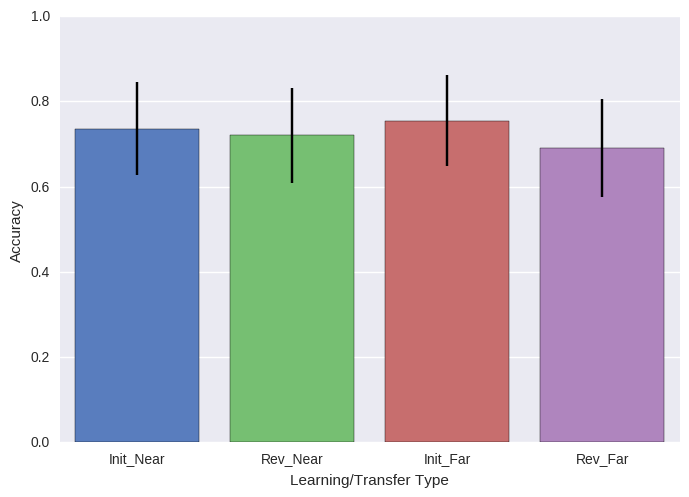

In [5]:
import seaborn as sns
#sns.set_style("ticks")
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 4
conditions = ['Init_Near', 'Rev_Near', 'Init_Far', 'Rev_Far']
acc_means_allsubjs = [np.average(init_near_acc), np.average(rev_near_acc),
                      np.average(init_far_acc), np.average(rev_far_acc)]
acc_sem_allsubjs = [np.std(init_near_acc)/(np.sqrt(len(subs))), np.std(rev_near_acc)/(np.sqrt(len(subs))),
                    np.std(init_far_acc)/(np.sqrt(len(subs))), np.std(rev_far_acc)/(np.sqrt(len(subs)))]
print acc_means_allsubjs
print acc_sem_allsubjs

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, acc_means_allsubjs, yerr = acc_sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylim(0,1)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Learning/Transfer Type")



plt.show()

# Learning Curve Analysis #1
### Create 2 learning curves near vs far for reversal runs only

In [6]:
%matplotlib inline
import os
from os.path import join
import numpy as np
import pandas as pd
from glob import glob
from scipy.integrate import simps, trapz
import matplotlib.pyplot as plt
from pylab import *

### NOTE !! ONLY NEED TO RUN THIS ONCE FOR EACH PARTICIPANT

#### This cell will take the log file and isolate the correct/incorrect performance for each stimulus type 1-8 and then save a .csv file in each participant's directory

In [7]:
subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_007', 'RL2_008','RL2_009', 
        'RL2_010', 'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018']          



# Get the CSV file for each participant
for curr_sub in subs:
    curr_dir = '/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/data/'
    dir_file = curr_dir + '{0}.csv'.format(curr_sub)
   
    # Open CVS file using Pandas
    sub_file = pd.read_csv(dir_file)
    # Obtain all rows in trial_acc with 0 or 1 only -- no nonresponse trials
    # Creates new array sans gaps in csv file
    sub_rows = sub_file.query('trial_acc == 0 or trial_acc == 1')


    # Loop once for each run (6) -- 0, 200, 400, 600, 800, 1000
    for i, run_num in enumerate(range(0, 1200, 200)):
        curr_run = sub_rows[run_num : run_num + 200]            
        # Compute the set number (0,1,2)
        j = int(run_num / 400)
        # Isolate columns for both response maps (run 1 & run 2)
        resp_map1 = curr_run['resp_map1_{0}'.format(j)].values[-1]
        resp_map2 = curr_run['resp_map2_{0}'.format(j)].values[-1]
        #print resp_map1
        #print resp_map2     

        # Replace comma-less blanks with comma blanks
        if type(resp_map1) == str and not "," in resp_map1: 
            resp_map1 = resp_map1.replace(" ", ", ")
        if type(resp_map2) == str and not "," in resp_map2: 
            resp_map2 = resp_map2.replace(" ", ", ")

        # Convert strings to lists
        resp_map1 = np.array(eval(resp_map1))
        resp_map2 = np.array(eval(resp_map2))

        # Grab rows in which absolute value of curr_stim (indicated by index location) resp_map2
        # less resp_map1 is either 2 or 1 --> indicating far or near transfer, respectively
        # Values in these arrays indicate which stimulus is a near or far transfer
        near_transfers = np.where((abs(resp_map2 - resp_map1) == 1))
        far_transfers = np.where((abs(resp_map2 - resp_map1) == 2)) 

        # Identifies trials with only near transfer stimuli
        near_query = curr_run.query('stim_type == {0} or stim_type == {1} or stim_type == {2} or stim_type == {3}'.format
                                       (*near_transfers[0]))
        # Grabs near transfer accuracy
        near_trans_acc = near_query['trial_acc'].values


        far_query = curr_run.query('stim_type == {0} or stim_type == {1} or stim_type == {2} or stim_type == {3}'.format
                                       (*far_transfers[0]))
        far_trans_acc = far_query['trial_acc'].values
        
        if not os.path.exists(join('/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/learning_analysis/all_levels', 
                                   '{0}'.format(curr_sub))):
            os.makedirs(join('/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/learning_analysis/all_levels', 
                             '{0}'.format(curr_sub)))

        np.savetxt(join('/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/learning_analysis/all_levels', 
                        '{0}/run{1}_near_acc.txt'.format(curr_sub, i+1)), 
                   near_trans_acc, delimiter = '\t', fmt = '%.0f')

        np.savetxt(join('/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/learning_analysis/all_levels', 
                        '{0}/run{1}_far_acc.txt'.format(curr_sub, i+1)), 
                   far_trans_acc, delimiter = '\t', fmt = '%.0f')




### You MUST run the wmazebl_plotmemstr.m file in matlab. Remember to navigate to the Learning Analysis folder to add it to path.
#### This will calculate the relevant pmode, p95, p05 data and save the text files that are required for the below cell. The script in this cell reads in the pmode, p95 and p05 for each fract image [1-8] and plots them along with chance performance 50% correct across all trials.
#### Learning is typically defined as the trial when the lower bound of the 95% confidence interva crosses and stays above chance performance

#### Red line = probability of being correct on any given trial (x-axis)
#### Black lines = 95% confidence interval around the probability correct curve
#### Blue line = chance performance

Subject RL2_001
Stimulus Set 1


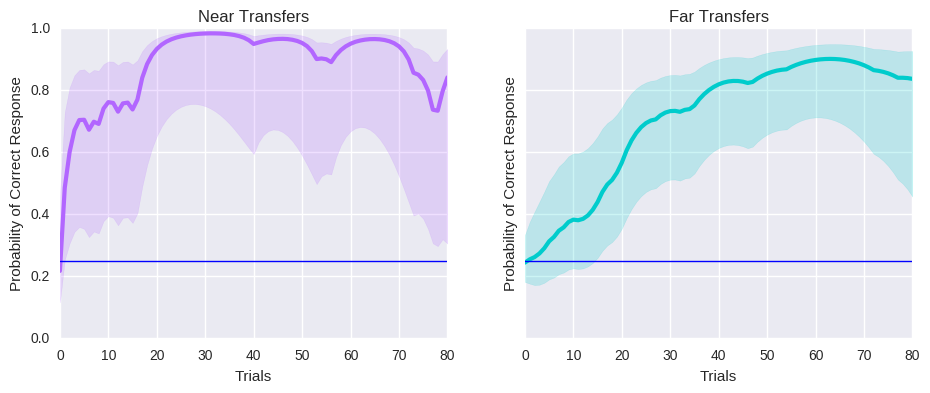

Subject RL2_001
Stimulus Set 2


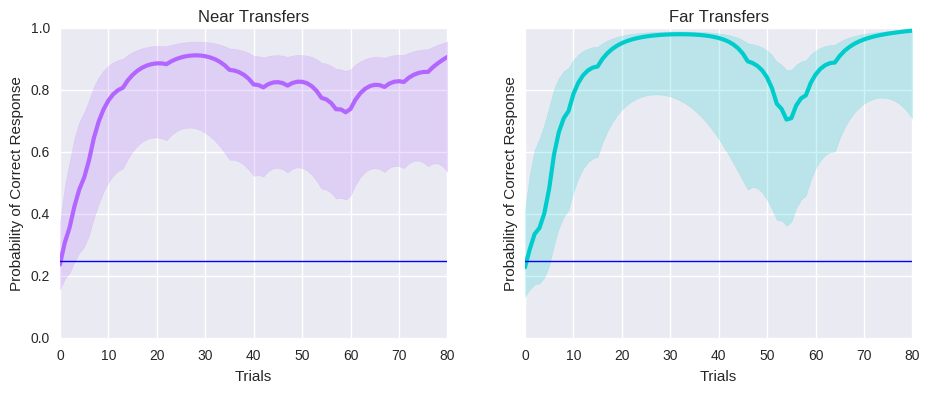

Subject RL2_001
Stimulus Set 3


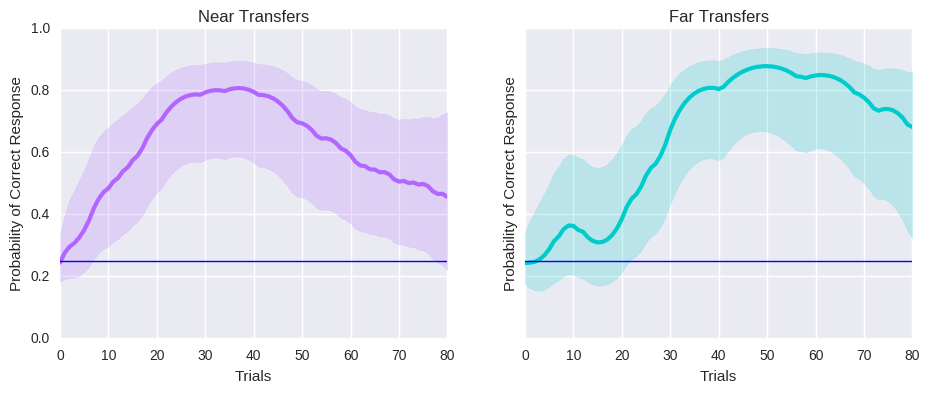

Subject RL2_002
Stimulus Set 1


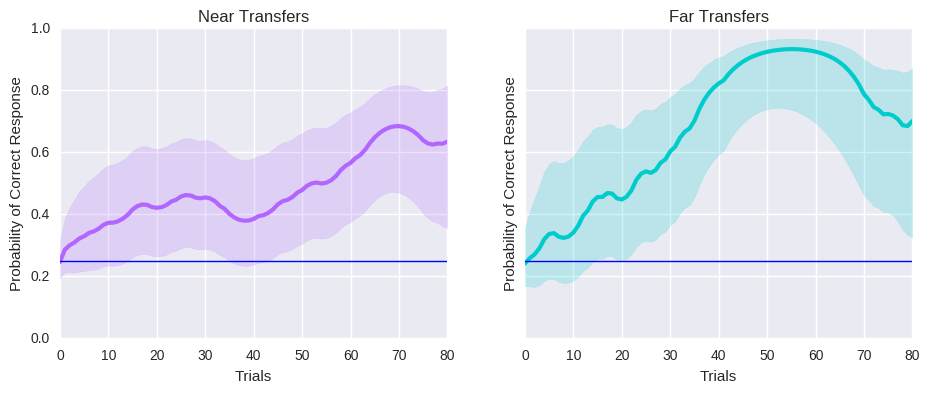

Subject RL2_002
Stimulus Set 2


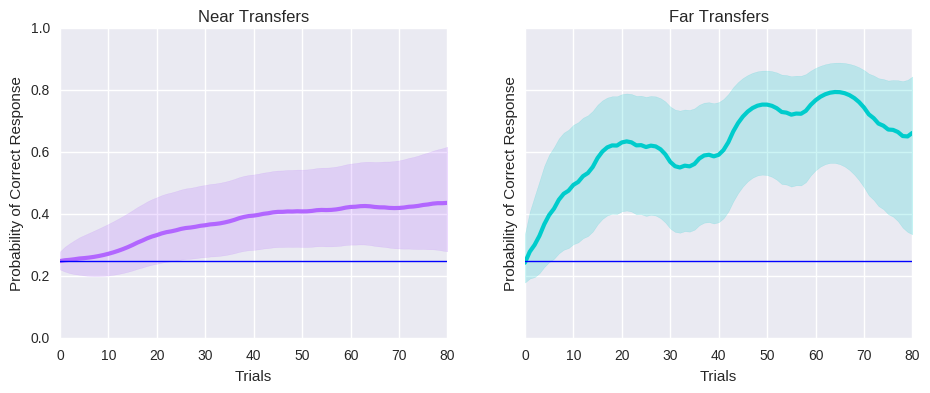

Subject RL2_002
Stimulus Set 3


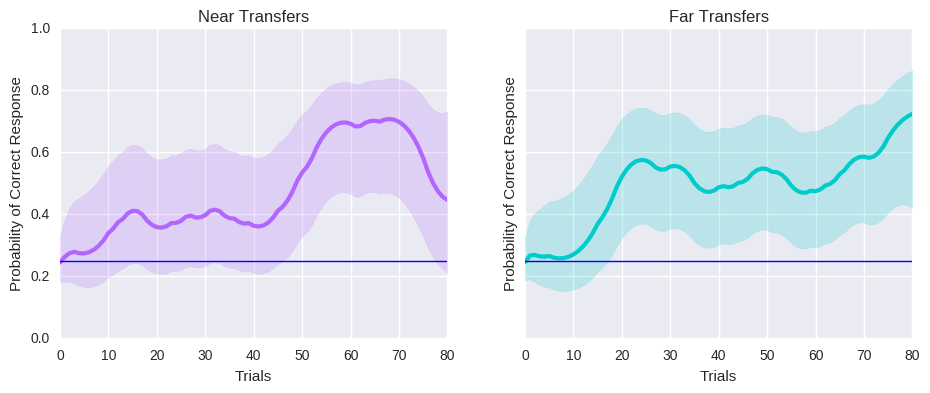

Subject RL2_003
Stimulus Set 1


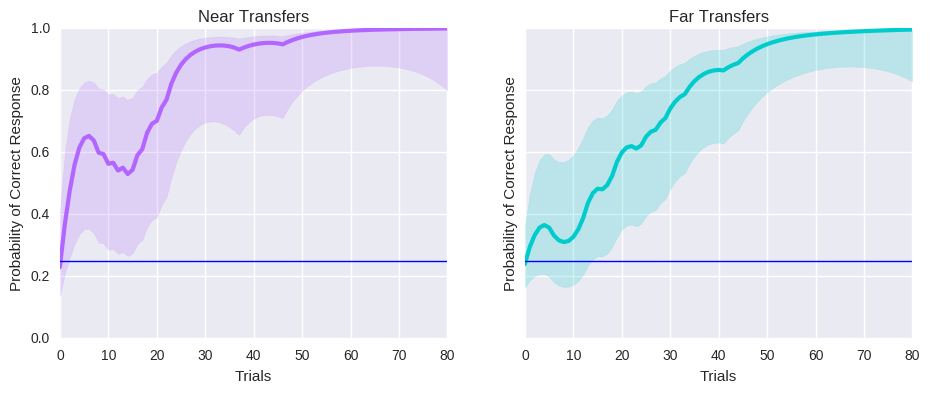

Subject RL2_003
Stimulus Set 2


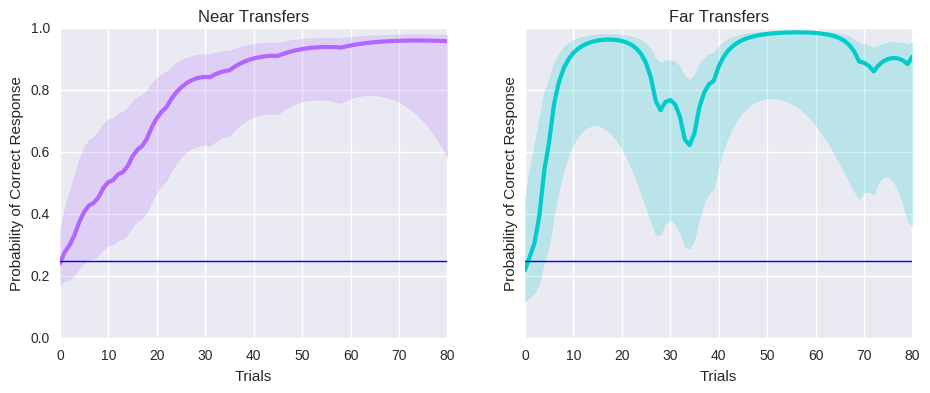

Subject RL2_003
Stimulus Set 3


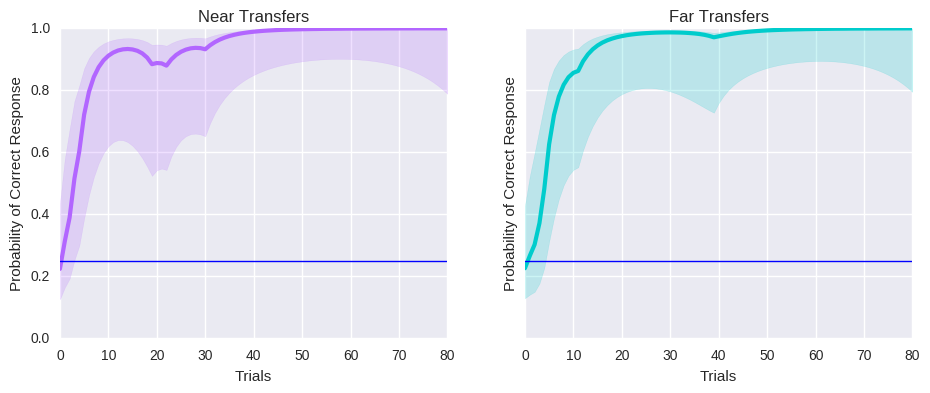

Subject RL2_004
Stimulus Set 1


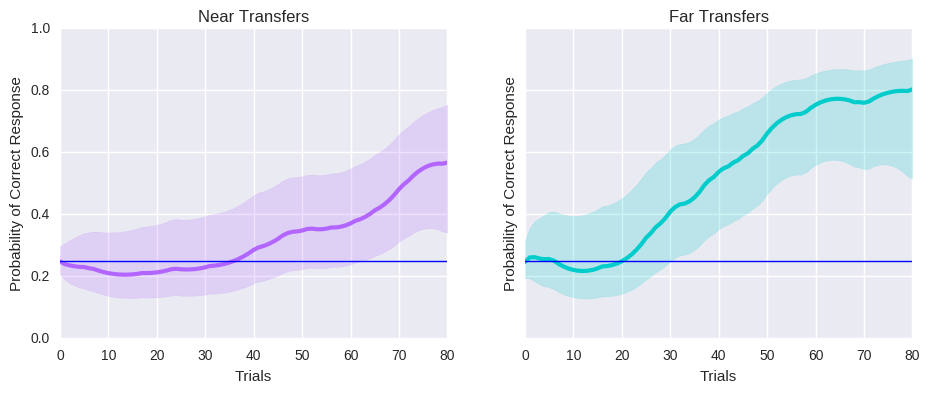

Subject RL2_004
Stimulus Set 2


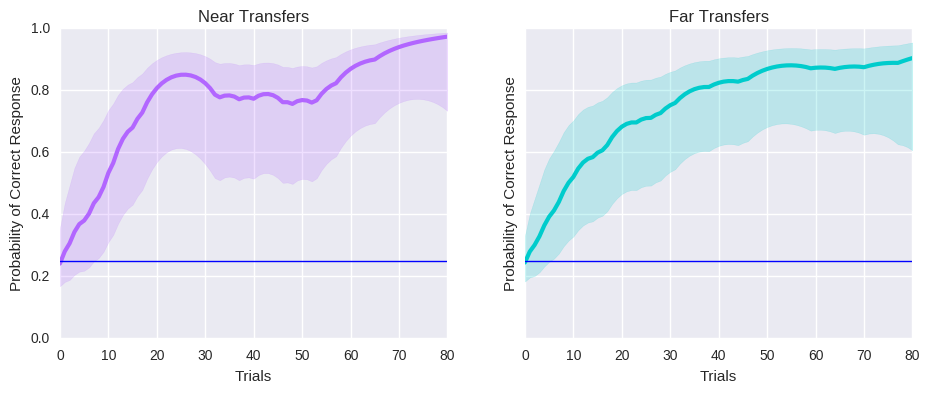

Subject RL2_004
Stimulus Set 3


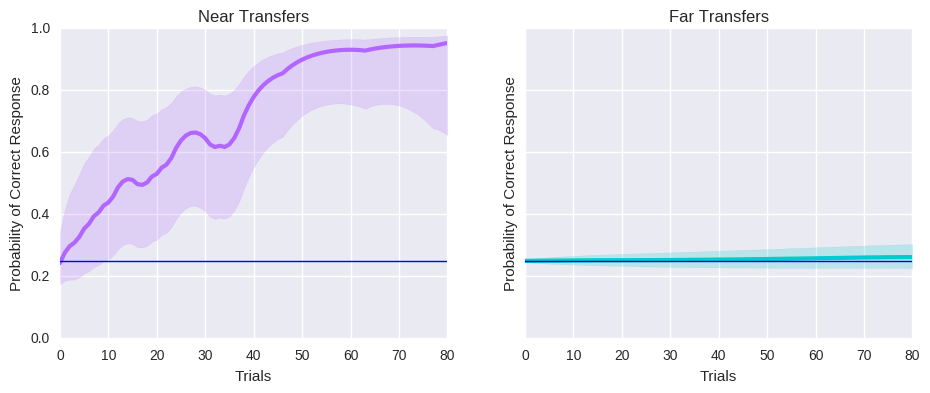

Subject RL2_005
Stimulus Set 1


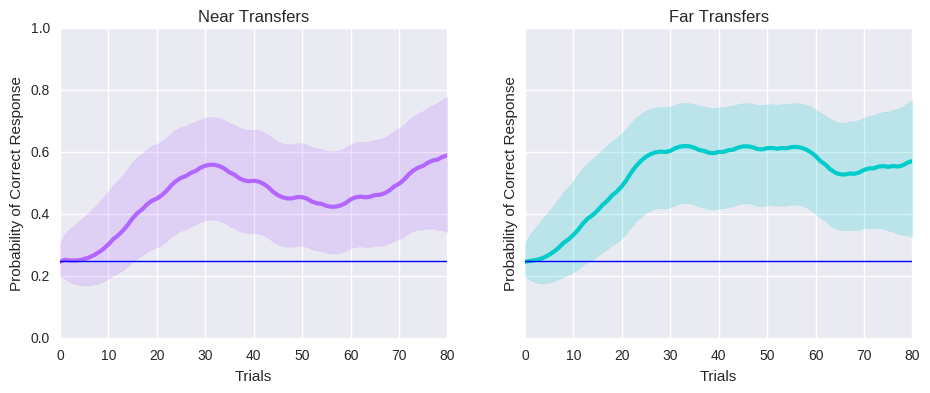

Subject RL2_005
Stimulus Set 2


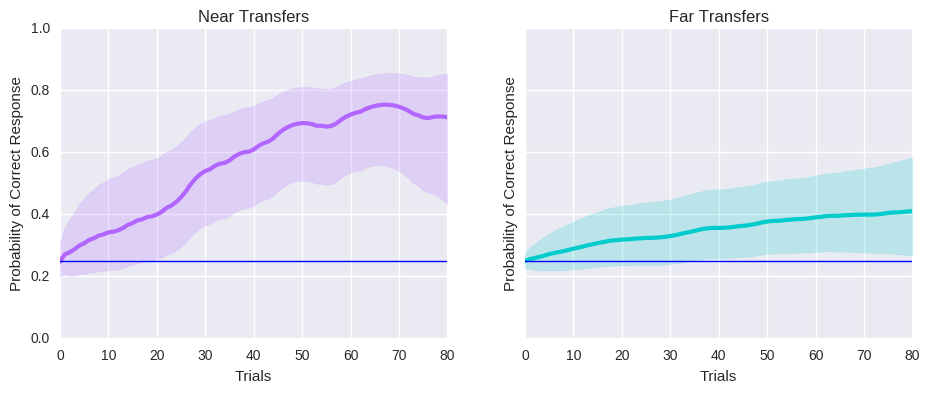

Subject RL2_005
Stimulus Set 3


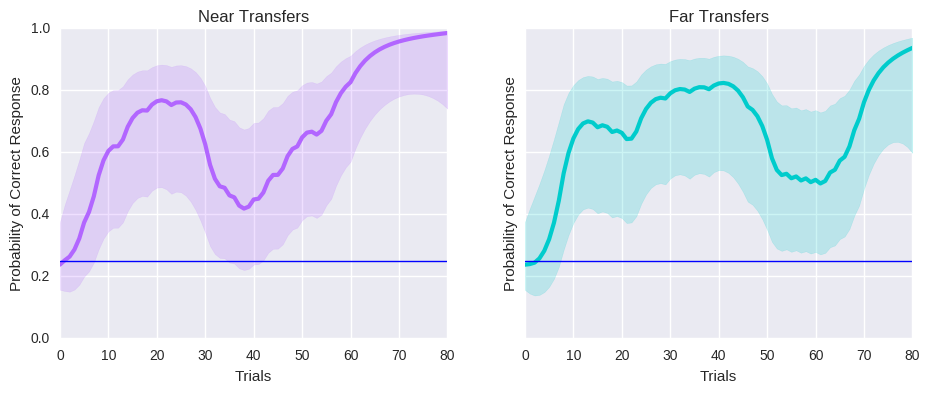

Subject RL2_006
Stimulus Set 1


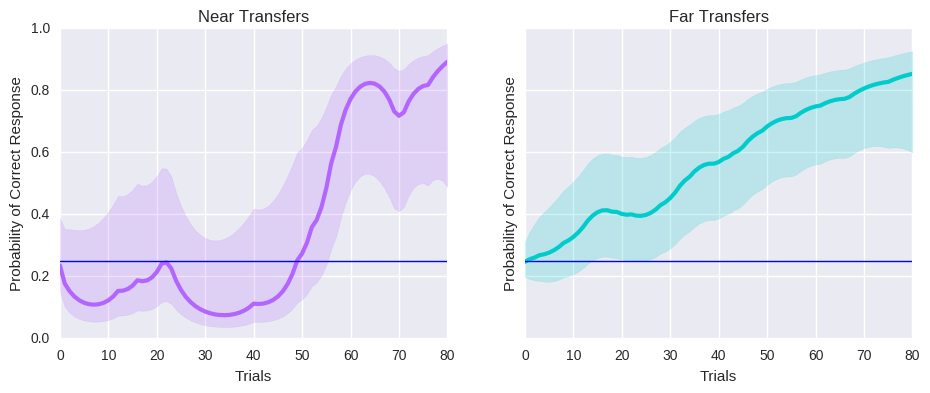

Subject RL2_006
Stimulus Set 2


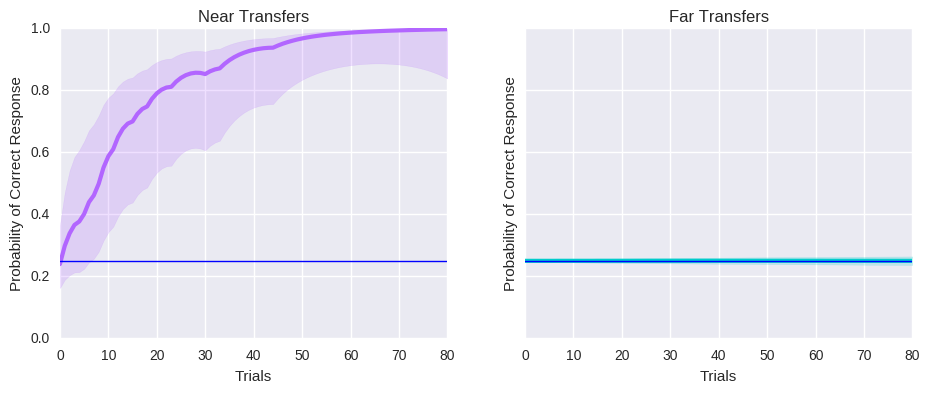

Subject RL2_006
Stimulus Set 3


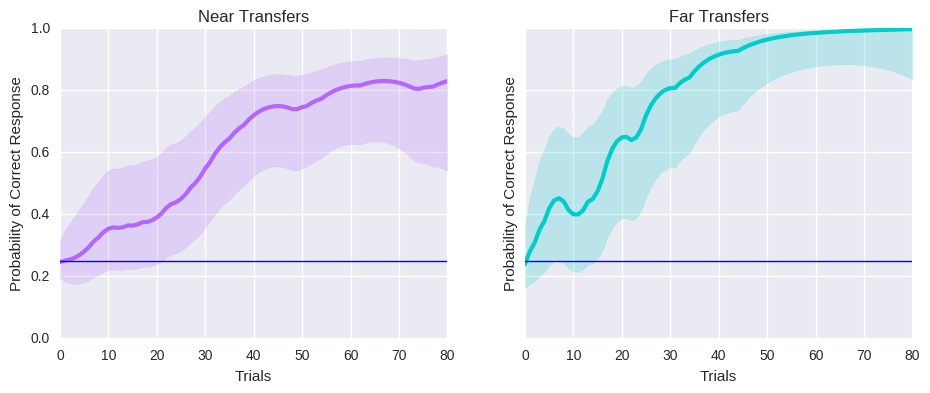

Subject RL2_008
Stimulus Set 1


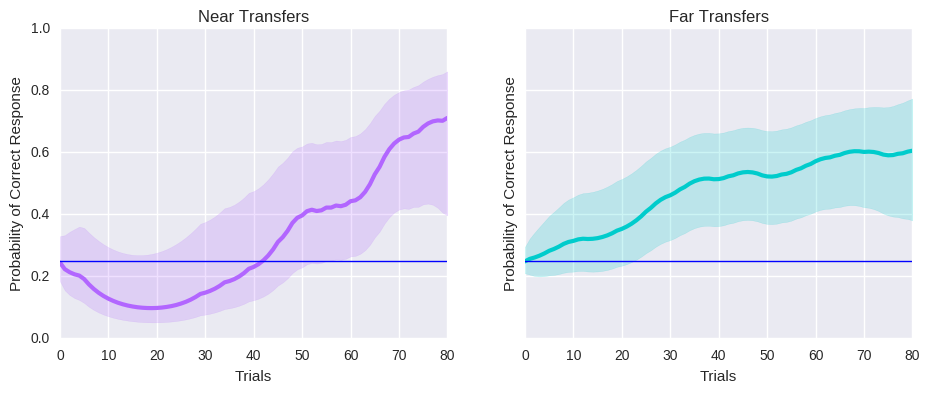

Subject RL2_008
Stimulus Set 2


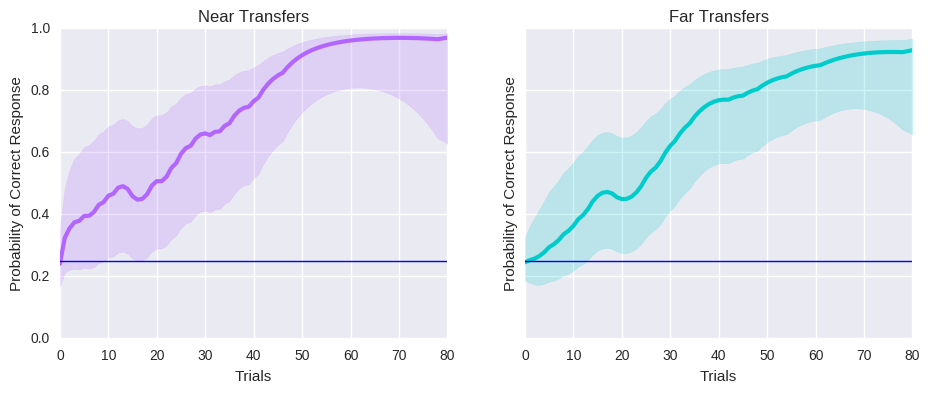

Subject RL2_008
Stimulus Set 3


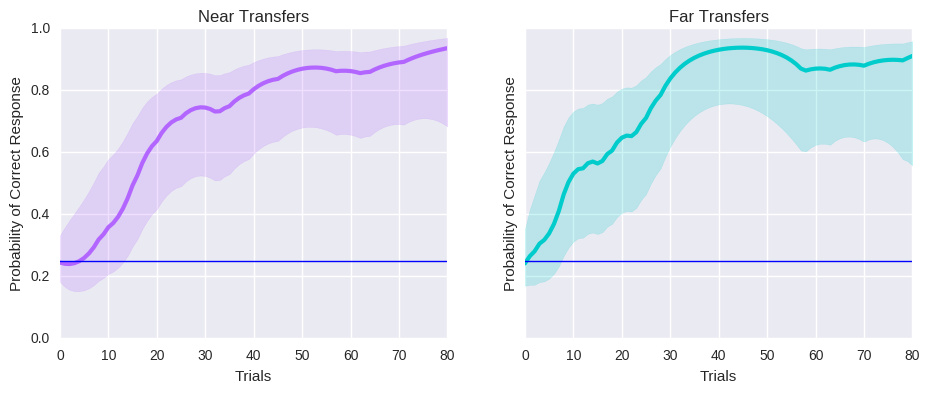

Subject RL2_009
Stimulus Set 1


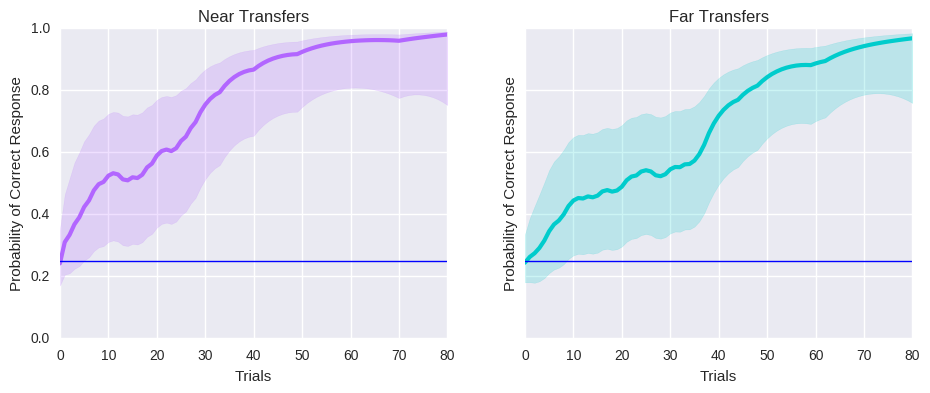

Subject RL2_009
Stimulus Set 2


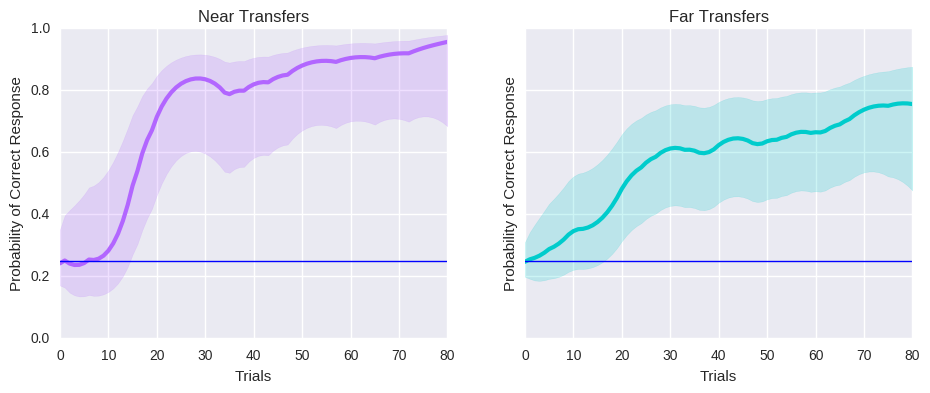

Subject RL2_009
Stimulus Set 3


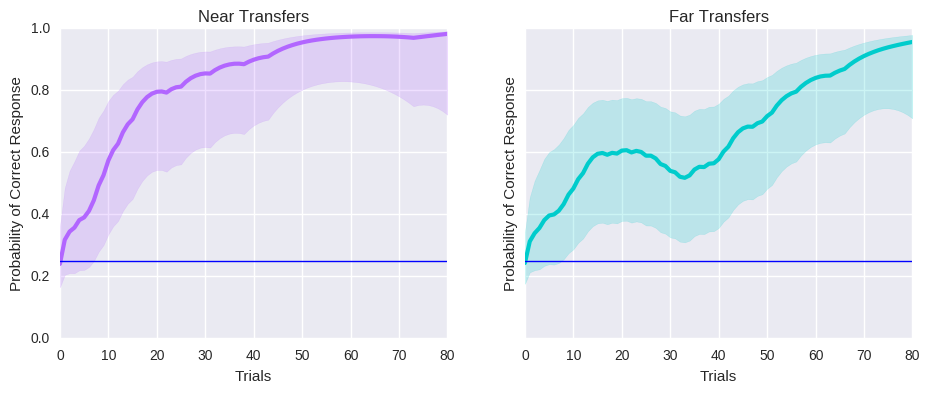

Subject RL2_011
Stimulus Set 1


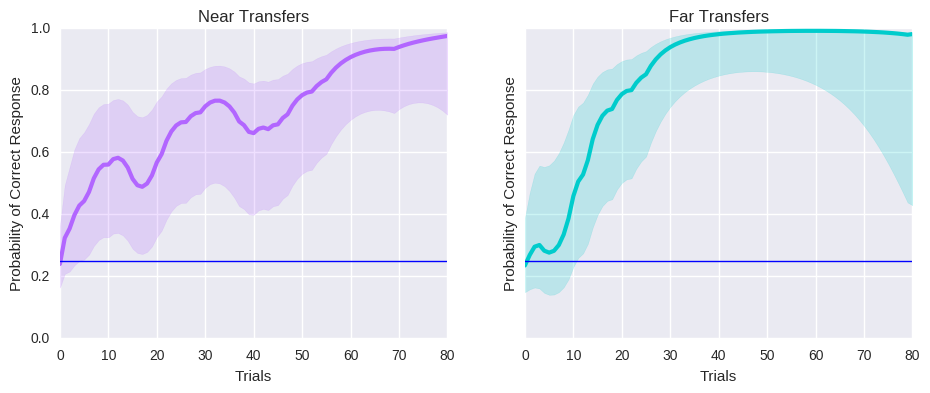

Subject RL2_011
Stimulus Set 2


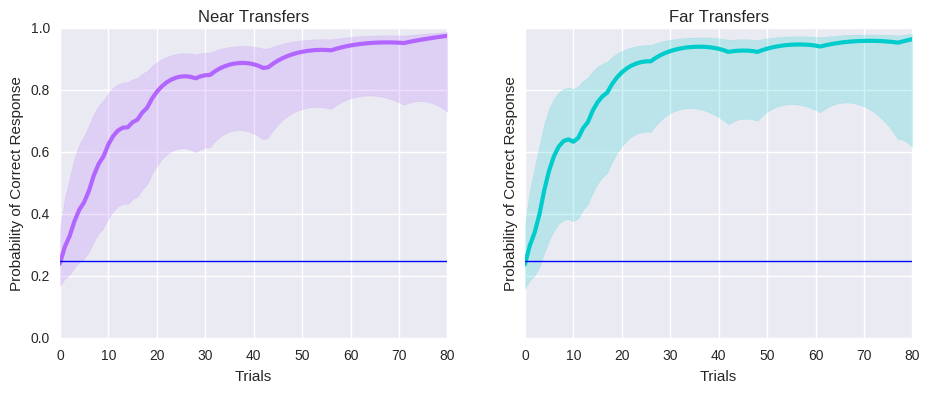

Subject RL2_011
Stimulus Set 3


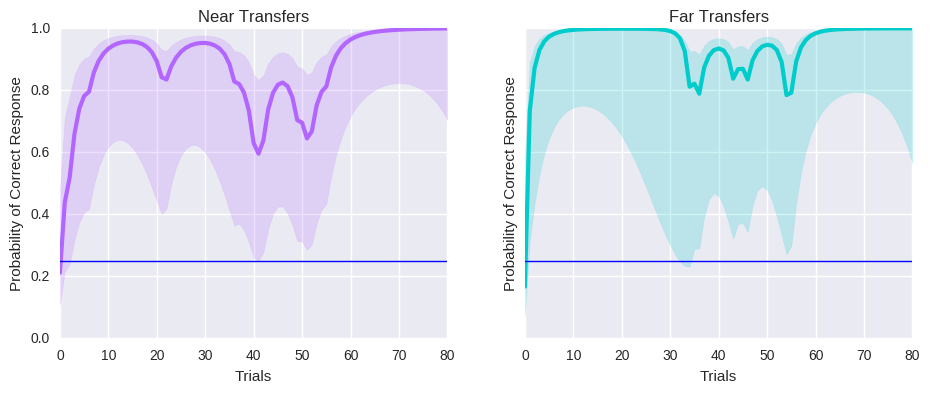

Subject RL2_012
Stimulus Set 1


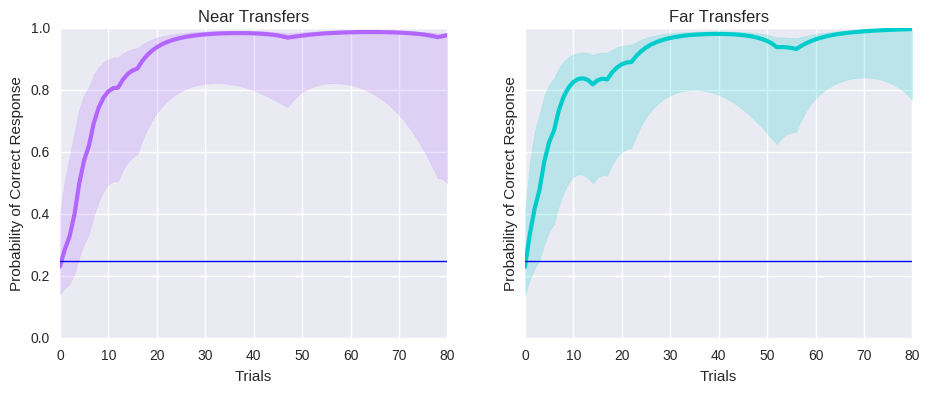

Subject RL2_012
Stimulus Set 2


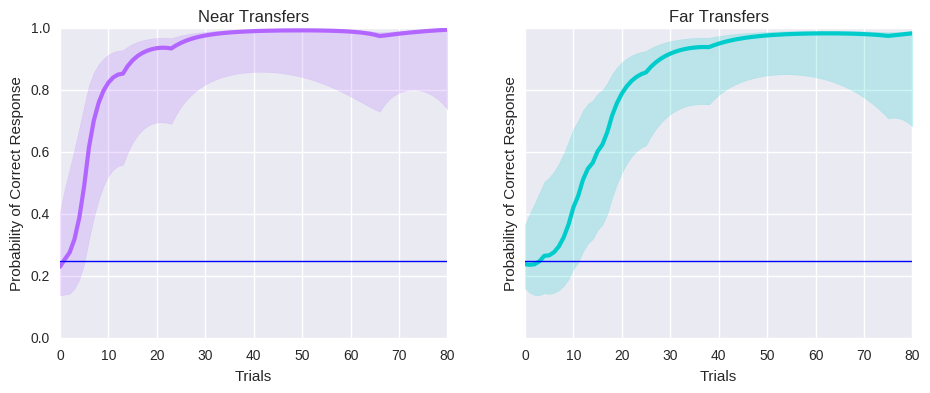

Subject RL2_012
Stimulus Set 3


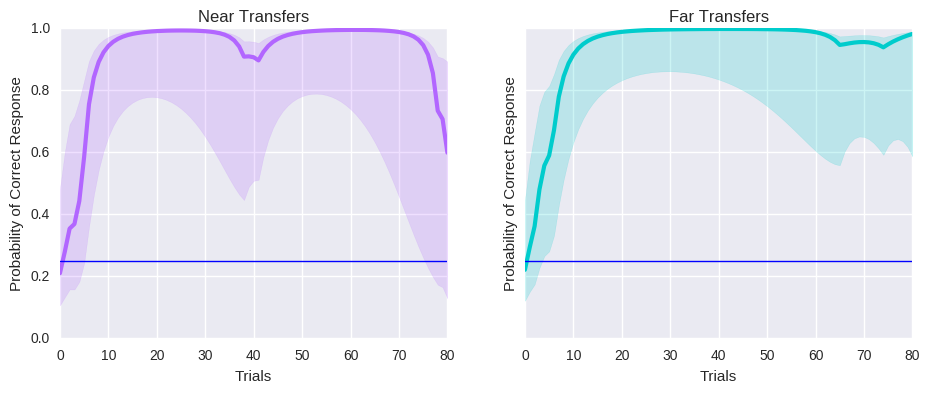

Subject RL2_013
Stimulus Set 1


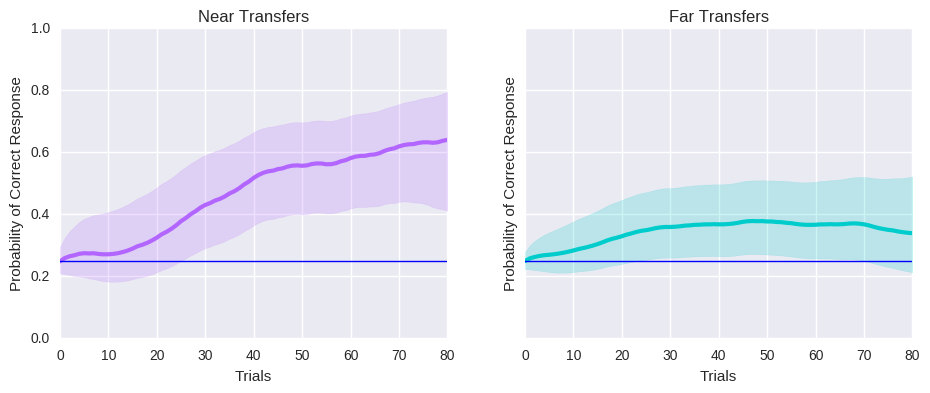

Subject RL2_013
Stimulus Set 2


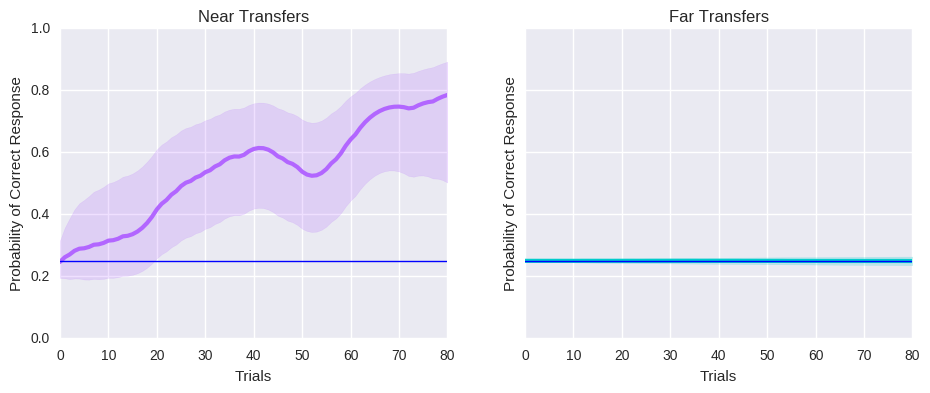

Subject RL2_013
Stimulus Set 3


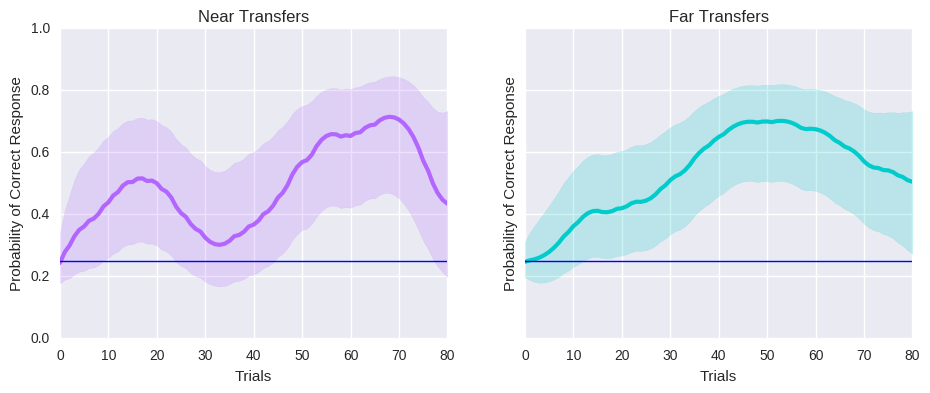

Subject RL2_014
Stimulus Set 1


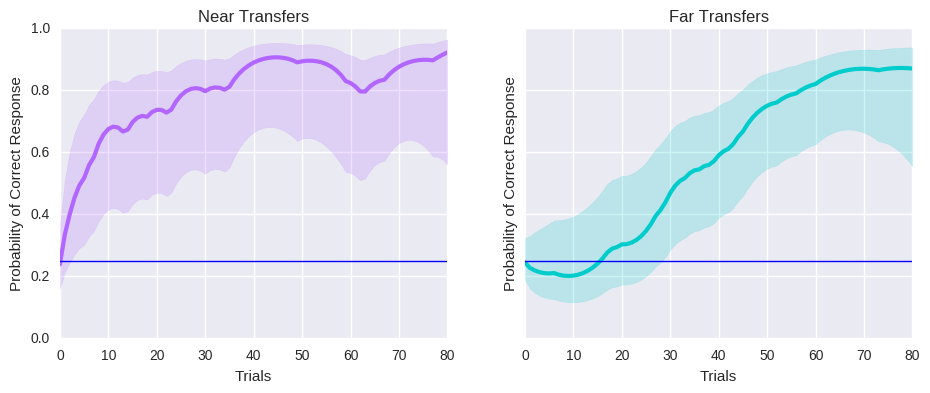

Subject RL2_014
Stimulus Set 2


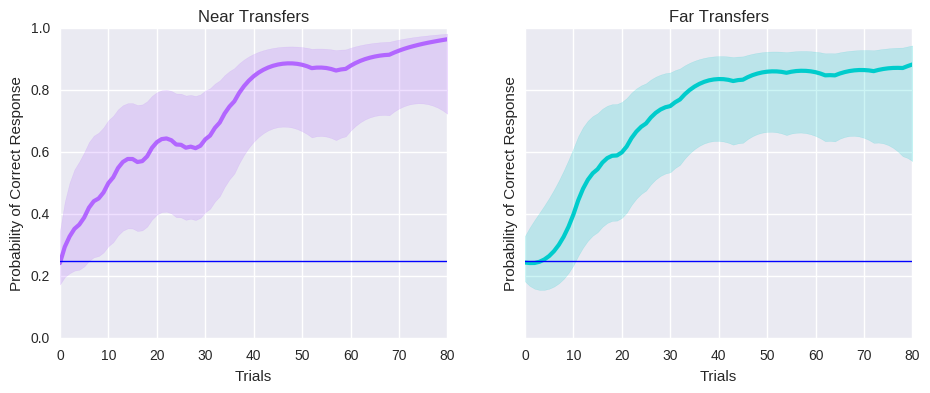

Subject RL2_014
Stimulus Set 3


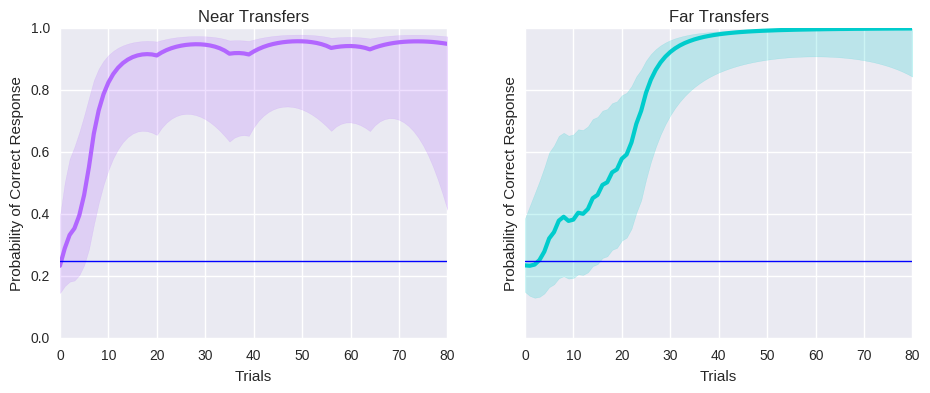

Subject RL2_015
Stimulus Set 1


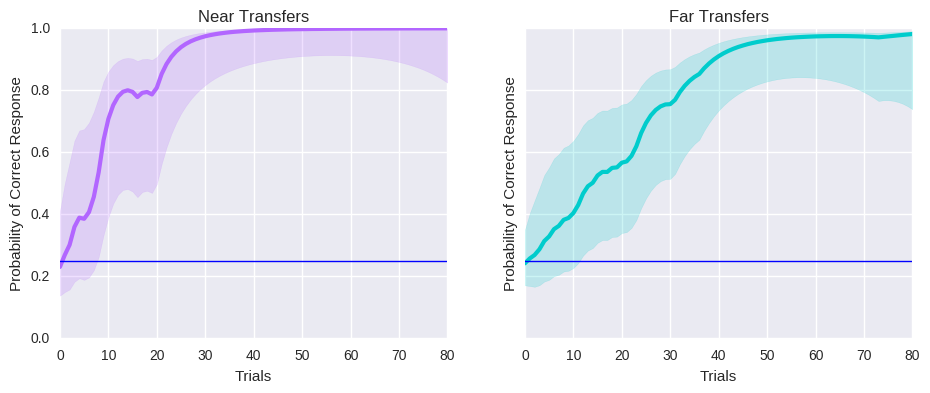

Subject RL2_015
Stimulus Set 2


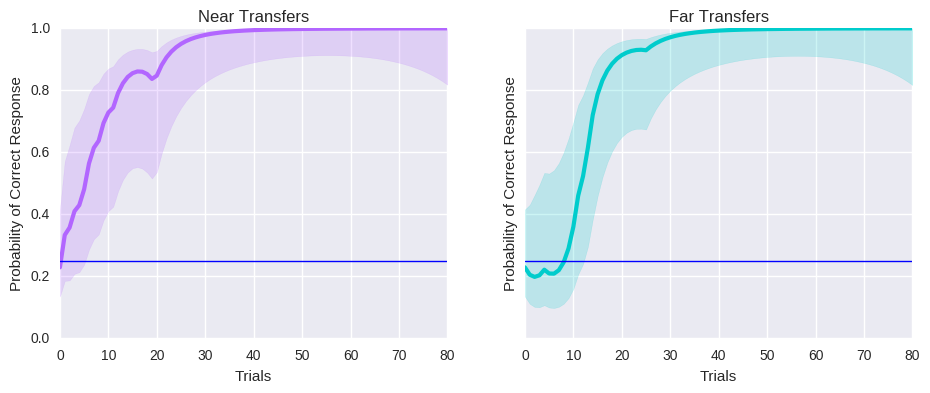

Subject RL2_015
Stimulus Set 3


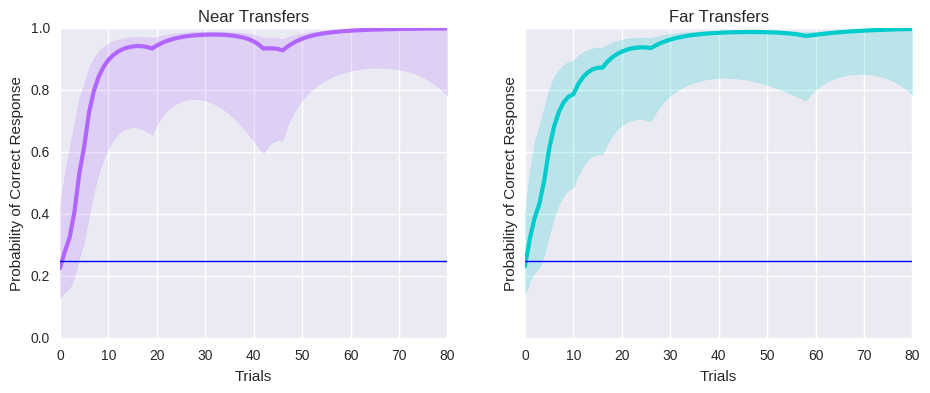

Subject RL2_016
Stimulus Set 1


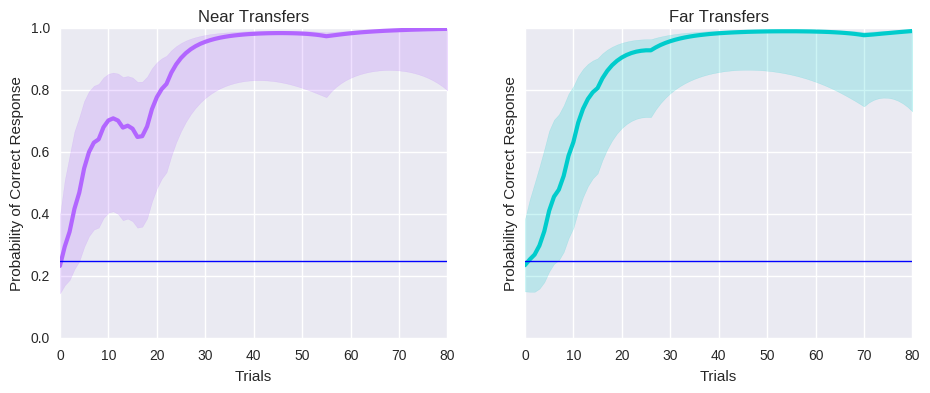

Subject RL2_016
Stimulus Set 2


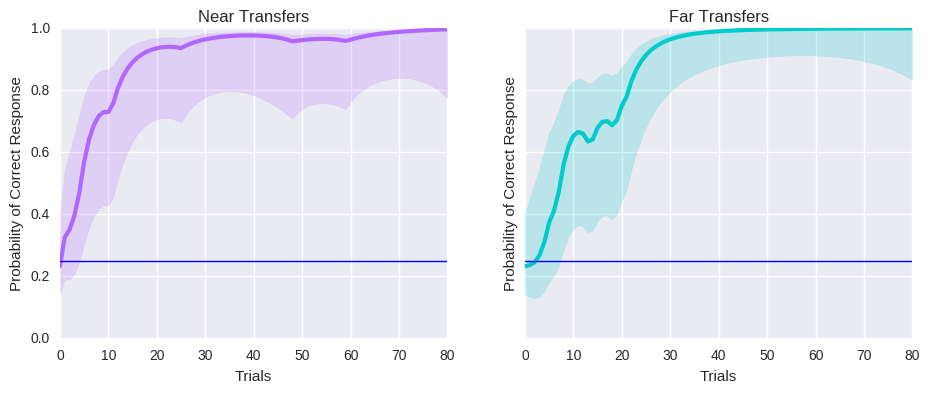

Subject RL2_016
Stimulus Set 3


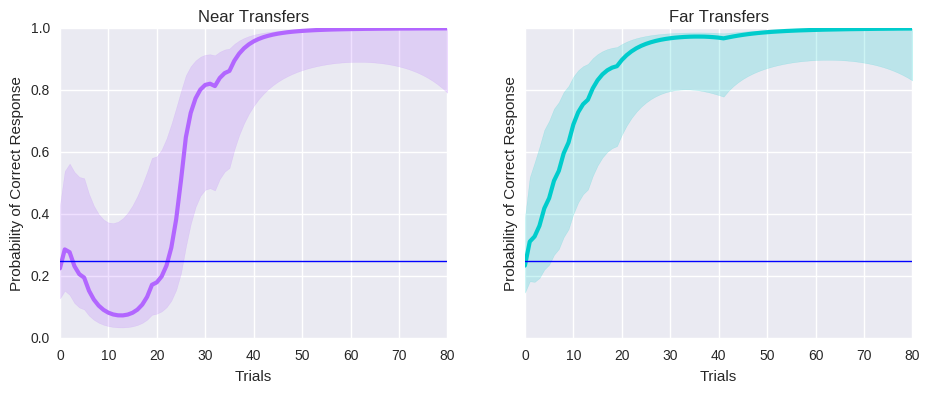

Subject RL2_017
Stimulus Set 1


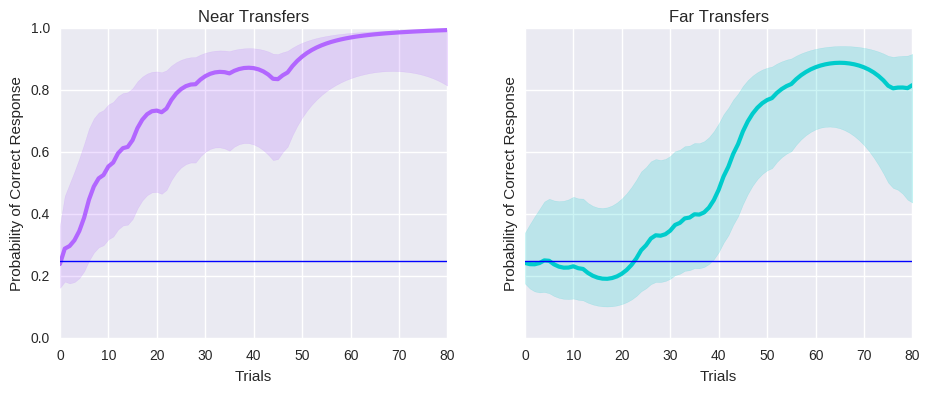

Subject RL2_017
Stimulus Set 2


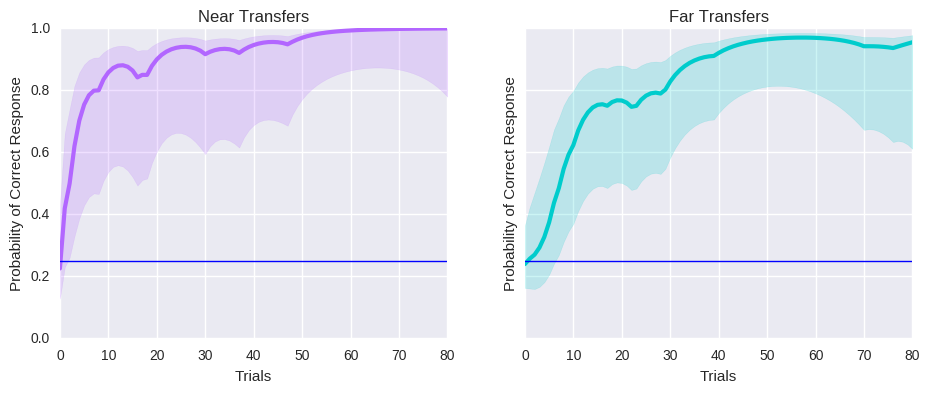

Subject RL2_017
Stimulus Set 3


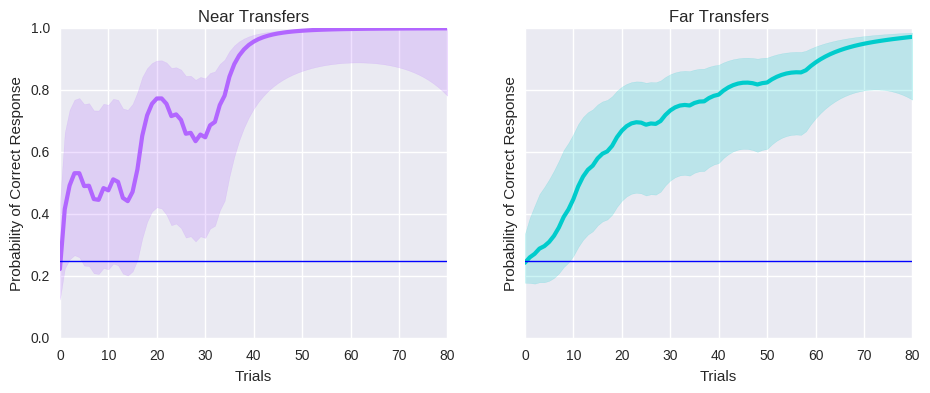

Subject RL2_018
Stimulus Set 1


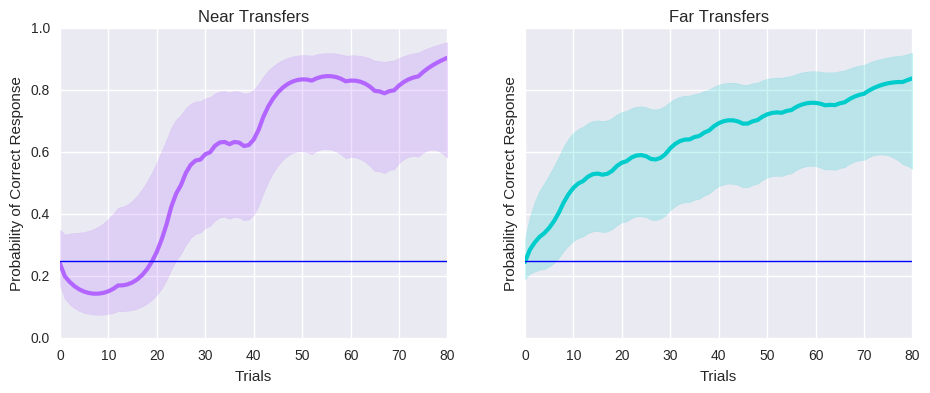

Subject RL2_018
Stimulus Set 2


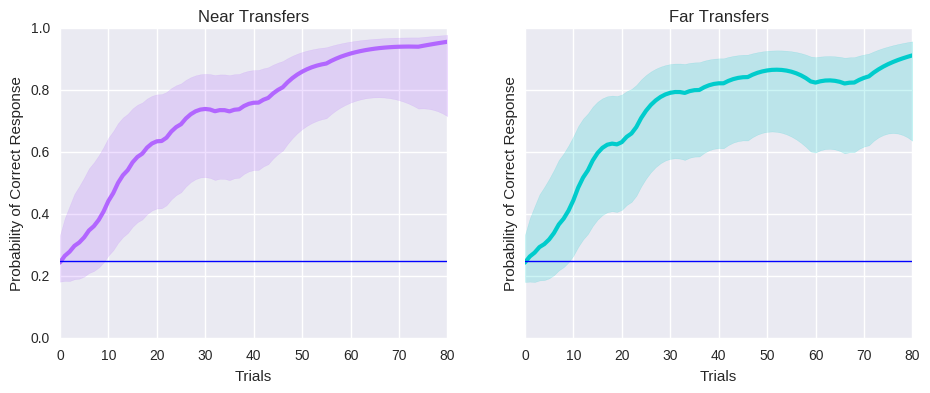

Subject RL2_018
Stimulus Set 3


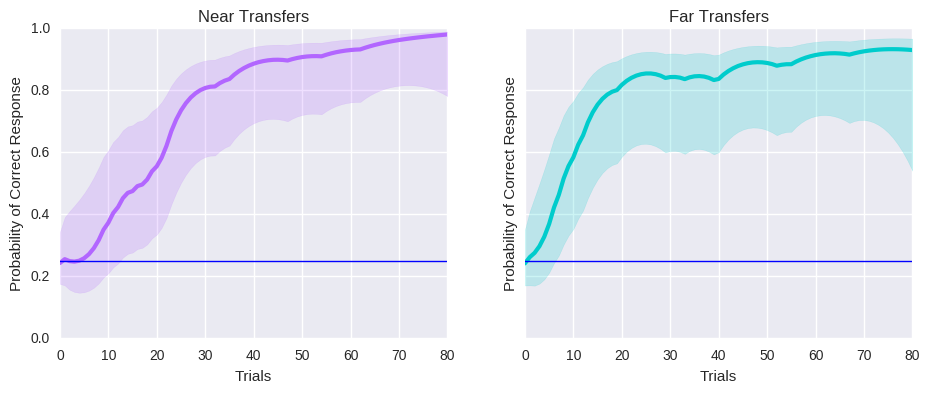

In [8]:
#subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_007', 'RL2_008','RL2_009', 
#        'RL2_010', 'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018']          
       
# Subjects for whom the lower bound confidence interval exceeded 0.25 (removal of 007 and 010)
subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_008', 'RL2_009', 
        'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018'] 
 

sets = ['1', '2', '3']


# For each sub, get all accuracy text files produced in the matlab script
for sub in subs:
    curr_dir = '/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/learning_analysis/transfers/{0}/'.format(sub)
    # For the current stimulus set
    for curr_set in sets:
        # Files obtained from MatLab script
        # Near Transfers
        near_pmode_filename = curr_dir + 'set{0}_near_pmode.txt'.format(curr_set)
        near_p95_filename = curr_dir + 'set{0}_near_p95.txt'.format(curr_set) 
        near_p05_filename = curr_dir + 'set{0}_near_p05.txt'.format(curr_set)
        near_pmode = np.genfromtxt(near_pmode_filename)
        near_p05 = np.genfromtxt(near_p05_filename)
        near_p95 = np.genfromtxt(near_p95_filename)
        near_prime_pmode = np.gradient(near_pmode)
        near_prime_pmode_ten = near_prime_pmode * 10        
        # Far Transfers
        far_pmode_filename = curr_dir + 'set{0}_far_pmode.txt'.format(curr_set)
        far_p95_filename = curr_dir + 'set{0}_far_p95.txt'.format(curr_set) 
        far_p05_filename = curr_dir + 'set{0}_far_p05.txt'.format(curr_set)
        far_pmode = np.genfromtxt(far_pmode_filename)
        far_p05 = np.genfromtxt(far_p05_filename)
        far_p95 = np.genfromtxt(far_p95_filename)
        far_prime_pmode = np.gradient(far_pmode)
        far_prime_pmode_ten = far_prime_pmode * 10
        
        x = range(len(near_pmode))
        chance = np.ones(len(x)) * 0.25

        fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
        ax0.plot(x, near_pmode, "#B266FF", linewidth = 3)
        ax0.fill_between(x, near_p95, near_p05, color = "#B266FF", alpha = 0.2)
        ax0.plot(x, chance, 'b', linewidth = 1)

        ax1.plot(x, far_pmode, "#00CCCC", linewidth = 3)
        ax1.fill_between(x, far_p95, far_p05, color = "#00CCCC", alpha = 0.2)
        ax1.plot(x, chance, 'b', linewidth = 1)

        ax0.set_ylim(0,1)
        ax0.set_xlabel('Trials')
        ax0.set_ylabel('Probability of Correct Response')
        ax0.set_title('Near Transfers')

        ax1.set_ylim(0,1)
        ax1.set_xlabel('Trials')
        ax1.set_ylabel('Probability of Correct Response')
        ax1.set_title('Far Transfers')
        print 'Subject ' + sub
        print 'Stimulus Set ' + curr_set
        plt.show()

## Area Under the Curve Analysis -- Near vs. Far Boxplot

### The code below reading in the pmode for each stimulus type and each subject and calculates the
###  The AUC is calculated using the scipy trapz integration function with a dx step size of 0.01


In [ ]:
#subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_007', 'RL2_008','RL2_009', 
#        'RL2_010', 'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018']  

# Subjects for whom the lower bound confidence interval exceeded 0.25 (removal of 007 and 010)
subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_008', 'RL2_009', 
        'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018'] 
 
sets = ['1', '2', '3']

# Dictionary to contain all AUC information for each set and transfer
auc_all_trans = {'set1_near_trans_AUC': [], 'set1_far_trans_AUC': [],
                 'set2_near_trans_AUC': [], 'set2_far_trans_AUC': [],
                 'set3_near_trans_AUC': [], 'set3_far_trans_AUC': []}

# For the current sub, define pathways to pmode files for each set and transfer
for sub in subs:
    for curr_set in sets:
        curr_dir = '/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/learning_analysis/transfers/{0}/'.format(sub)
        near_pmode_filename = curr_dir + 'set{0}_near_pmode.txt'.format(curr_set)
        far_pmode_filename = curr_dir + 'set{0}_far_pmode.txt'.format(curr_set)

        # Load near and far p_mode files
        near_pmode = np.genfromtxt(near_pmode_filename)
        far_pmode = np.genfromtxt(far_pmode_filename)
        
        # Use the trapz function to produce AUC for each set
        auc_near = trapz(near_pmode, dx = 0.01)
        auc_far = trapz(far_pmode, dx = 0.01)

        # Append each set AUC to all transfer dictionary
        auc_all_trans['set{0}_near_trans_AUC'.format(curr_set)].append(auc_near)
        auc_all_trans['set{0}_far_trans_AUC'.format(curr_set)].append(auc_far)

# This cell plots the AUC data determined above as a box plot.
# Green line = AUC for chance performance
# Red square = Mean AUC
# Red line = Median AUC
# Initial learning (Runs 1, 3, & 5 exclusively) 

auc_plot_data1 = []
auc_plot_data1.append(auc_all_trans['set1_near_trans_AUC'])
auc_plot_data1.append(auc_all_trans['set1_far_trans_AUC'])
auc_plot_data1.append(auc_all_trans['set2_near_trans_AUC'])
auc_plot_data1.append(auc_all_trans['set2_far_trans_AUC'])
auc_plot_data1.append(auc_all_trans['set3_near_trans_AUC'])
auc_plot_data1.append(auc_all_trans['set3_far_trans_AUC'])

labels = ['Set1_Near', 'Set1_Far', 'Set2_Near', 'Set2_Far', 'Set3_Near', 'Set3_Far']
x = range(len(labels) + 2)
chance = np.ones(len(x)) * 0.25

fig, ax0 = plt.subplots(figsize = (10,5))
bp = plt.boxplot(auc_plot_data1, labels = labels, showmeans = True)
#ax0.set_ylim(0,1)
ax0.set_ylabel("Area Under the Curve (AUC)")
ax0.set_xlabel('Transfer Set/Type')
ax0.set_title("AUC: Near vs. Far Transfers")
ax0.plot(x, chance, 'g', linewidth = 1)
plt.show()

## Learning Curve Analysis #2
### Combines initial and reversal runs

In [ ]:
# All subjects
#subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_007', 'RL2_008','RL2_009', 
#        'RL2_010', 'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018']          


# Subjects for whom the lower bound confidence interval exceeded 0.25 (removal of 007 and 010)
subs = ['RL2_001', 'RL2_002', 'RL2_003', 'RL2_004', 'RL2_005', 'RL2_006', 'RL2_008', 'RL2_009', 
        'RL2_011', 'RL2_012', 'RL2_013', 'RL2_014', 'RL2_015', 'RL2_016', 'RL2_017', 'RL2_018']  

runs = ['1', '2', '3', '4', '5', '6']

lrn_dict = {'init_nears':[], 'init_fars':[], 'rev_nears':[],  'rev_fars':[]}

# For each sub, get all accuracy text files produced in the matlab script
for sub in subs:
    curr_dir = '/home/data/madlab/data/mri/rev_lrn/pilot_data/behavioral/learning_analysis/all_levels/{0}/'.format(sub)    
    
    # 6 runs
    for i, curr_run in enumerate(runs):
        sub_dict = {'init_near_crosses':[], 'init_far_crosses':[], 'rev_near_crosses':[],  'rev_far_crosses':[]}
        # Files obtained from MatLab script
        # Near Transfers
        near_pmode_filename = curr_dir + 'run{0}_near_pmode.txt'.format(curr_run)
        near_p95_filename = curr_dir + 'run{0}_near_p95.txt'.format(curr_run) 
        near_p05_filename = curr_dir + 'run{0}_near_p05.txt'.format(curr_run)
        near_pmode = np.genfromtxt(near_pmode_filename)
        near_p05 = np.genfromtxt(near_p05_filename)
        near_p95 = np.genfromtxt(near_p95_filename)
        near_prime_pmode = np.gradient(near_pmode)
        near_prime_pmode_ten = near_prime_pmode * 10        
        # Far Transfers
        far_pmode_filename = curr_dir + 'run{0}_far_pmode.txt'.format(curr_run)
        far_p95_filename = curr_dir + 'run{0}_far_p95.txt'.format(curr_run) 
        far_p05_filename = curr_dir + 'run{0}_far_p05.txt'.format(curr_run)
        far_pmode = np.genfromtxt(far_pmode_filename)
        far_p05 = np.genfromtxt(far_p05_filename)
        far_p95 = np.genfromtxt(far_p95_filename)
        far_prime_pmode = np.gradient(far_pmode)
        far_prime_pmode_ten = far_prime_pmode * 10
        
        x = range(len(near_pmode))
        chance = np.ones(len(x)) * 0.25
        
        # identifies nears over chance
        for j, curr_np05 in enumerate(near_p05):           
            # print curr_np05            
            if i%2 == 0: #initial runs
                if curr_np05 >= 0.25:
                    sub_dict['init_near_crosses'].append(j)
            else: # reversal runs
                if curr_np05 >= 0.25: 
                    sub_dict['rev_near_crosses'].append(j)
        
                    
        # identifies fars over chance            
        for k, curr_fp05 in enumerate(far_p05):             
            if i%2 == 0: # initial runs
                if curr_fp05 >= 0.25: 
                    sub_dict['init_far_crosses'].append(k)
            else: # reversal runs
                if curr_fp05 >= 0.25: 
                    sub_dict['rev_far_crosses'].append(k)
                    
        #print sub  
        #print curr_run
        #print sub_dict
                    
        # Append the first near/far >= chance to the appropriate sub_dict key 
        if i%2 == 0: # initial runs
            # Initial nears
            if len(sub_dict['init_near_crosses']) != 0:
                lrn_dict['init_nears'].append(sub_dict['init_near_crosses'][0])
            else:
                lrn_dict['init_nears'].append(80)
            # Initial fars
            if len(sub_dict['init_far_crosses']) != 0:
                lrn_dict['init_fars'].append(sub_dict['init_far_crosses'][0])
            else:
                lrn_dict['init_fars'].append(80)
        else: # reversal runs
            # Reversal nears
            if len(sub_dict['rev_near_crosses']) != 0:
                lrn_dict['rev_nears'].append(sub_dict['rev_near_crosses'][0])    
            else:
                lrn_dict['rev_nears'].append(80)
            # Reversal fars    
            if len(sub_dict['rev_far_crosses']) != 0:   
                lrn_dict['rev_fars'].append(sub_dict['rev_far_crosses'][0])
            else:
                lrn_dict['rev_fars'].append(80)
                     
        
        fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
        ax0.plot(x, near_pmode, "#B266FF", linewidth = 3)
        ax0.fill_between(x, near_p95, near_p05, color = "#B266FF", alpha = 0.2)
        ax0.plot(x, chance, 'b', linewidth = 1)

        ax1.plot(x, far_pmode, "#00CCCC", linewidth = 3)
        ax1.fill_between(x, far_p95, far_p05, color = "#00CCCC", alpha = 0.2)
        ax1.plot(x, chance, 'b', linewidth = 1)

        ax0.set_ylim(0,1)
        ax0.set_xlabel('Trials')
        ax0.set_ylabel('Probability of Correct Response')
        ax0.set_title('Near Transfers')

        ax1.set_ylim(0,1)
        ax1.set_xlabel('Trials')
        ax1.set_ylabel('Probability of Correct Response')
        ax1.set_title('Far Transfers')
        print 'Subject ' + sub
        print 'Run ' + curr_run
        plt.show()
        
    #print sub_dict       
#print lrn_dict

## Learning Rate Analysis (5% confidence): Near Transfers
### Uses point at which 5% lower confidence interval exceeds chance (0.25)

In [ ]:
print len(lrn_dict['init_nears']), len(lrn_dict['rev_nears'])
#Rate of learning
nearlearn_t_acc, nearlearn_p_acc = stats.ttest_rel(lrn_dict['init_nears'], lrn_dict['rev_nears'])
print "Near Learning"
print nearlearn_t_acc
print "p-Value"
print nearlearn_p_acc

# t-test requires arrays of equal length -- 006 (Run 3) and 010 (Run 1) removed for failure to exceed chance performance 

## Learning Rate Analysis (5% confidence): Far Transfers
### Uses point at which 5% lower confidence interval exceeds chance (0.25)

In [ ]:
print len(lrn_dict['init_fars']), len(lrn_dict['rev_fars'])
#Rate of learning
farlearn_t_acc, farlearn_p_acc = stats.ttest_rel(lrn_dict['init_fars'], lrn_dict['rev_fars'])
print "Far Learning"
print farlearn_t_acc
print "p-Value"
print farlearn_p_acc

# t-test requires arrays of equal length -- 006 and 013 removed for failure to exceed chance performance

## Rate of Learning (window version) -- Near Transfers
### Uses the information obtained with the threshold finder function
#### 40% performance criterion -- 10 trial windows

In [ ]:
#print run_dict['run1_near']
#print run_dict['run2_near']
#print run_dict['run3_near']
#print run_dict['run4_near']
#print run_dict['run5_near']
#print run_dict['run6_near']

#Rate of learning 
#Compares the trial window at which participants reached criterion for initial vs reversal near transfers across runs
nearlearn_t_acc, nearlearn_p_acc = stats.ttest_rel(run_dict['run1_near'] + run_dict['run3_near'] + run_dict['run5_near'],
                                                   run_dict['run2_near'] + run_dict['run4_near'] + run_dict['run6_near'])
print "Related Sample t-Test"
print nearlearn_t_acc
print "p-Value"
print nearlearn_p_acc

## Rate of Learning (window version) -- Far Transfers
### Uses the information obtained with the threshold finder function
#### 40% performance criterion -- 10 trial windows

In [ ]:
#print run_dict['run1_far']
#print run_dict['run2_far']
#print run_dict['run3_far']
#print run_dict['run4_far']
#print run_dict['run5_far']
#print run_dict['run6_far']

#Rate of learning
#Compares the trial window at which participants reached criterion for initial vs reversal far transfers
farlearn_t_acc, farlearn_p_acc = stats.ttest_rel(run_dict['run1_far'] + run_dict['run3_far'] + run_dict['run5_far'],
                                                 run_dict['run2_far'] + run_dict['run4_far'] + run_dict['run6_far'])
print "Related Sample t-Test"
print farlearn_t_acc
print "p-Value"
print farlearn_p_acc
